### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!unzip -q /content/gdrive/My\ Drive/CNN\ Assignment/CNN_assignment

In [4]:
!ls

 gdrive       'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [6]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [7]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
# Printing the count of images in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [13]:
new_labels = {}
for image, label in val_ds.take(3):
  for i in range(len(class_names)):
    if i in label.numpy() and i not in new_labels.keys():
      label_index = np.where(label==i)
      new_labels[i] = image[label_index[0][0]]
print(new_labels.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 0])


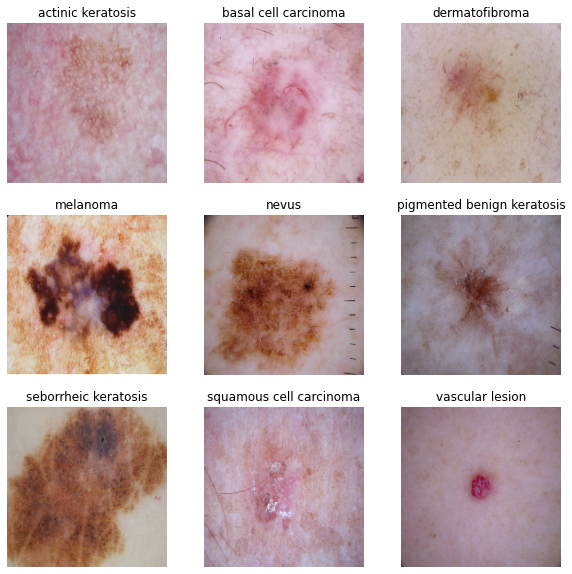

In [14]:
fig = plt.figure(figsize=[10,10])
for i in sorted(new_labels.keys()):
  ax = fig.add_subplot(3,3,i+1)
  plt.imshow(new_labels[i].numpy().astype('uint8'))
  plt.title(class_names[i])
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 90, 90, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)       1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 47s 117ms/step - loss: 1.9862 - accuracy: 0.4012 - val_loss: 2.2076 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 1.1516 - accuracy: 0.6094 - val_loss: 2.2547 - val_accuracy: 0.1700
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 0.7597 - accuracy: 0.7288 - val_loss: 2.2850 - val_accuracy: 0.2819
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 0.5061 - accuracy: 0.8376 - val_loss: 2.6365 - val_accuracy: 0.2237
Epoch 5/20
56/56 [==============================] - 3s 58ms/step - loss: 0.3750 - accuracy: 0.8940 - val_loss: 2.2882 - val_accuracy: 0.2416
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 0.2575 - accuracy: 0.9291 - val_loss: 2.3051 - val_accuracy: 0.2796
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 0.1945 - accuracy: 0.9548 - val_loss: 1.9971 - val_accuracy: 0.3758
Epoch 8/20


### Visualizing training results

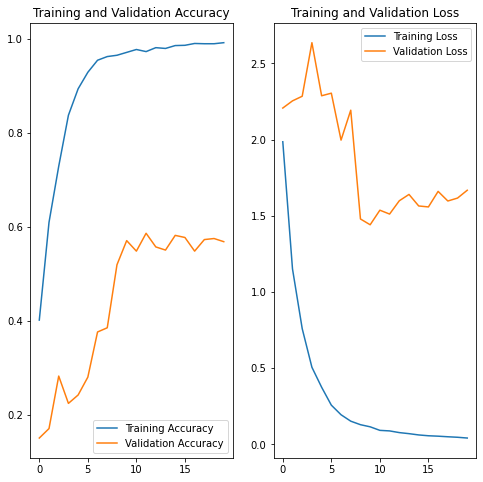

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**`OBSERVATIONS:`**
- The training accuracy is linearly increasing from 40% upto 99%. 
- The validation accuracy is linearly increasing from 14% upto 57% and is oscillating around 55%
- Can observe that training accuracy is almost near 100% and since there is a huge gap between the training and the validation set accuracy, i.e., around 30%, we can conclude that the model is **OVERFITTING**.


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

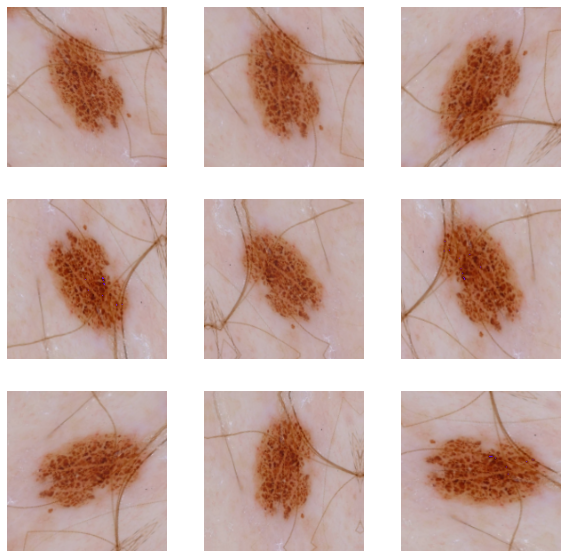

In [53]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



### Compiling the model

In [29]:
## Your code goes here
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 73ms/step - loss: 2.0254 - accuracy: 0.3767 - val_loss: 2.2385 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6216 - accuracy: 0.4660 - val_loss: 2.5022 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4411 - accuracy: 0.4989 - val_loss: 2.2278 - val_accuracy: 0.1812
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3327 - accuracy: 0.5251 - val_loss: 2.3172 - val_accuracy: 0.2438
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.2588 - accuracy: 0.5441 - val_loss: 2.3476 - val_accuracy: 0.2886
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.1549 - accuracy: 0.5915 - val_loss: 2.5413 - val_accuracy: 0.2550
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.1213 - accuracy: 0.5965 - val_loss: 1.7133 - val_accuracy: 0.4049
Epoch 8/20
56

### Visualizing the results

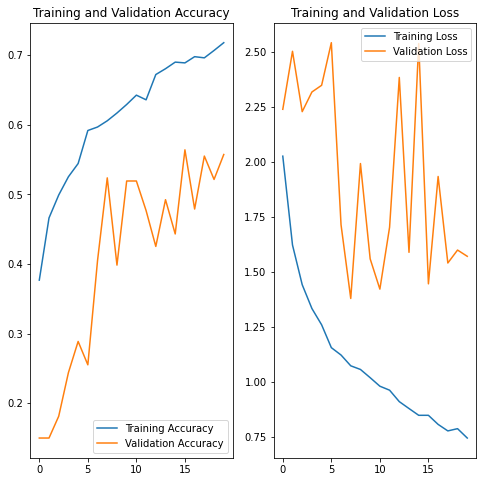

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**`OBSERVATIONS:`**
- The training accuracy is linearly increasing from 36% upto 72%. 
- The validation accuracy is linearly increasing from 14% upto 54% and is oscillating around 50%
- Can observe that training accuracy has come down to 72% and also the gap between the training and the validation set accuracy has reduced to 15%.
- **This shows that the model's overfitting has reduced, and the model has become more generalisable.**


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [33]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,vascular lesion
1,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2,Skin cancer ISIC The International Skin Imagin...,vascular lesion
3,Skin cancer ISIC The International Skin Imagin...,vascular lesion
4,Skin cancer ISIC The International Skin Imagin...,vascular lesion
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,melanoma
2235,Skin cancer ISIC The International Skin Imagin...,melanoma
2236,Skin cancer ISIC The International Skin Imagin...,melanoma
2237,Skin cancer ISIC The International Skin Imagin...,melanoma


Class=8, n=139 (6.208%)
Class=1, n=376 (16.793%)
Class=7, n=181 (8.084%)
Class=0, n=114 (5.092%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)


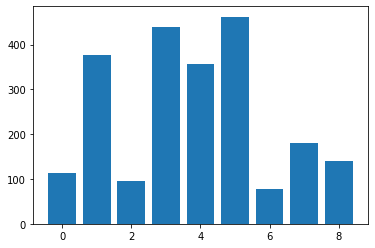

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**`OBSERVATIONS:`**
- **Class 6 - 'seborrheic keratosis'** has the least number of samples.
- **Classes 1,3,4 and 5 - 'basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis'** are dominating the data in terms of proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F24735F50>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F9F12FE90>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F24668BD0>: 100%|██████████| 500/500 [00:19<00:00, 26.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1F9F220750>: 100%|██████████| 500/500 [01:37<00:00,  5.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F1F90B19910>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F2458DF10>: 100%|██████████| 500/500 [00:19<00:00, 25.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1F9002E1D0>: 100%|██████████| 500/500 [00:49<00:00, 10.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F9EED0890>: 100%|██████████| 500/500 [00:19<00:00, 25.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F9EED8D50>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_7787be64-d526-4ef2-b781-8e266308be87.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_92414c68-901c-47d1-812f-cabaa00b8370.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031648.jpg_a3c55c59-e7e7-4017-9c3e-72e63e575526.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_932d58fc-728a-40cc-b1b2-2edda64c0f67.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032076.jpg_9aa89e57-aad4-4c77-b629-f0cdc709fbd5.jpg']

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 90, 90, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [50]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 104ms/step - loss: 20.4255 - accuracy: 0.3807 - val_loss: 19.9273 - val_accuracy: 0.1158
Epoch 2/30
169/169 [==============================] - 12s 71ms/step - loss: 17.6243 - accuracy: 0.4918 - val_loss: 17.2548 - val_accuracy: 0.3036
Epoch 3/30
169/169 [==============================] - 12s 70ms/step - loss: 15.4378 - accuracy: 0.5441 - val_loss: 14.7750 - val_accuracy: 0.4573
Epoch 4/30
169/169 [==============================] - 12s 70ms/step - loss: 13.5592 - accuracy: 0.5927 - val_loss: 12.7209 - val_accuracy: 0.5909
Epoch 5/30
169/169 [==============================] - 12s 70ms/step - loss: 11.9440 - accuracy: 0.6013 - val_loss: 11.5513 - val_accuracy: 0.5330
Epoch 6/30
169/169 [==============================] - 12s 70ms/step - loss: 10.5400 - accuracy: 0.6356 - val_loss: 11.3452 - val_accuracy: 0.3563
Epoch 7/30
169/169 [==============================] - 12s 70ms/step - loss: 9.2805 - accuracy: 0.6621 - val_loss: 9.7802 - 

#### **Todo:**  Visualize the model results

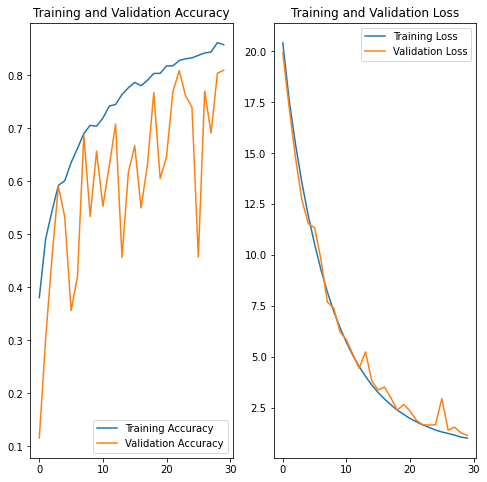

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**`ANALYSIS:`**
- Initially, the base model built was overfitting on the dataset.
- To overcome it, data augmentation and dropout techniques were used which helped control the overfitting of the model on the dataset, but it also brought down the performance of the model.
- The issue was due to class imbalance and was overcome by using the python package Augmentor, which helped in artifically adding more images to all classes mainly focusing on the imbalanced classes.
- The model trained after artificial generation of image data has a great improvement in performance, both in training as well as validation dataset.
- Training accuracy is at **85%** and Validation accuracy is at **80%**. 